In [1]:
import pandas as pd
import numpy as np

An important class of array transformations used for time series operations are statis‐
tics and other functions evaluated over a sliding window or with exponentially decay‐
ing weights. This can be useful for smoothing noisy or gappy data. I call these moving
window functions, even though it includes functions without a fixed-length window
like exponentially weighted moving average. Like other statistical functions, these
also automatically exclude missing data.

In [3]:
close_px_all = pd.read_csv('D:\python build app\laptop-victus\data\panda\Data-Aggregation-and-Group-Operations\stock_px.csv',
                           parse_dates=True, index_col=0)
close_px = close_px_all[['AAPL', 'MSFT', 'XOM']]
close_px = close_px.resample('B').ffill()

I now introduce the rolling operator, which behaves similarly to resample and
groupby. It can be called on a Series or DataFrame along with a window (expressed as
a number of periods; see Figure 11-4 for the plot created):

<Axes: >

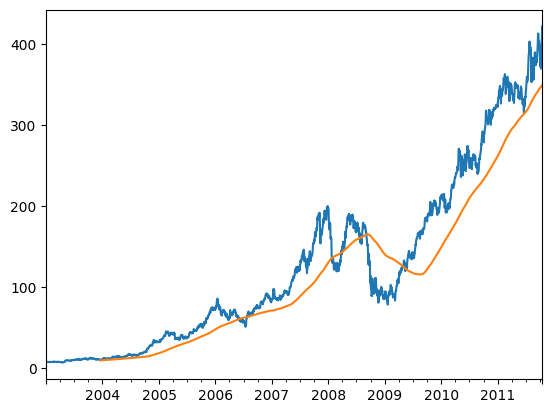

In [5]:
close_px.AAPL.plot()
close_px.AAPL.rolling(250).mean().plot()

The expression rolling(250) is similar in behavior to groupby, but instead of group‐
ing it creates an object that enables grouping over a 250-day sliding window. So here
we have the 250-day moving window average of Apple’s stock price.

By default rolling functions require all of the values in the window to be non-NA.
This behavior can be changed to account for missing data and, in particular, the fact
that you will have fewer than window periods of data at the beginning of the time
series (see Figure 11-5):

In [6]:
appl_std250 = close_px.AAPL.rolling(250, min_periods=10).std()
appl_std250[5:12]

2003-01-09         NaN
2003-01-10         NaN
2003-01-13         NaN
2003-01-14         NaN
2003-01-15    0.077496
2003-01-16    0.074760
2003-01-17    0.112368
Freq: B, Name: AAPL, dtype: float64

<Axes: >

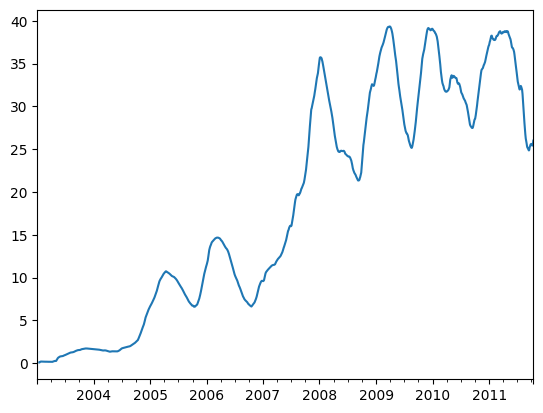

In [7]:
appl_std250.plot()

In order to compute an expanding window mean, use the expanding operator instead
of rolling. The expanding mean starts the time window from the beginning of the
time series and increases the size of the window until it encompasses the whole series.
An expanding window mean on the apple_std250 time series looks like this:

In [8]:
expanding_mean = appl_std250.expanding().mean()

Calling a moving window function on a DataFrame applies the transformation to
each column (see Figure 11-6):

<Axes: >

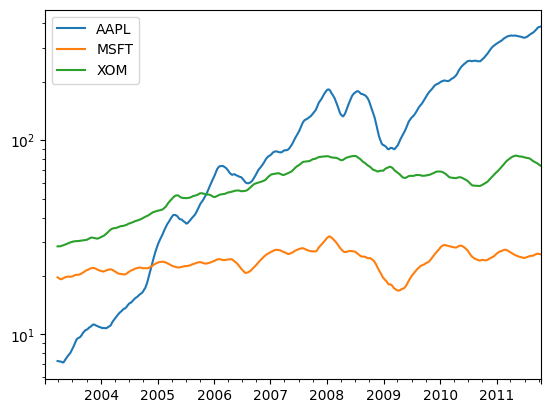

In [9]:
close_px.rolling(60).mean().plot(logy=True)

The rolling function also accepts a string indicating a fixed-size time offset rather
than a set number of periods. Using this notation can be useful for irregular time ser‐
ies. These are the same strings that you can pass to resample. For example, we could
compute a 20-day rolling mean like so:

In [10]:
close_px.rolling('20D').mean()

,AAPL,MSFT,XOM
2003-01-02,7.400000,21.110000,29.220000
2003-01-03,7.425000,21.125000,29.230000
2003-01-06,7.433333,21.256667,29.473333
2003-01-07,7.432500,21.425000,29.342500
2003-01-08,7.402000,21.402000,29.240000
...,...,...,...
2011-10-10,389.351429,25.602143,72.527857
2011-10-11,388.505000,25.674286,72.835000
2011-10-12,388.531429,25.810000,73.400714
2011-10-13,388.826429,25.961429,73.905000


### Exponentially Weighted Functions

An alternative to using a static window size with equally weighted observations is to
specify a constant decay factor to give more weight to more recent observations.
There are a couple of ways to specify the decay factor. A popular one is using a span,
which makes the result comparable to a simple moving window function with win‐
dow size equal to the span.

Since an exponentially weighted statistic places more weight on more recent observa‐
tions, it “adapts” faster to changes compared with the equal-weighted version.

pandas has the ewm operator to go along with rolling and expanding. Here’s an
example comparing a 60-day moving average of Apple’s stock price with an EW mov‐
ing average with span=60 (see Figure 11-7):

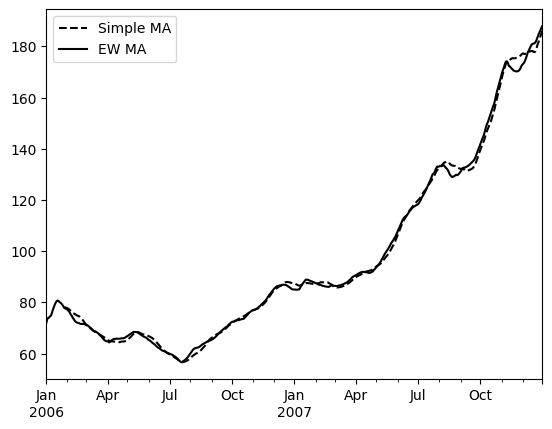

In [20]:
import matplotlib.pyplot as plt
aapl_px = close_px.AAPL['2006':'2007']
ma60 = aapl_px.rolling(30, min_periods=20).mean()
ewma60 = aapl_px.ewm(span=30).mean()
ma60.plot(style='k--', label='Simple MA')
ewma60.plot(style='k-', label='EW MA')
plt.legend()

### Binary Moving Window Functions

Some statistical operators, like correlation and covariance, need to operate on two
time series. As an example, financial analysts are often interested in a stock’s correla‐
tion to a benchmark index like the S&P 500. To have a look at this, we first compute
the percent change for all of our time series of interest:

<Axes: >

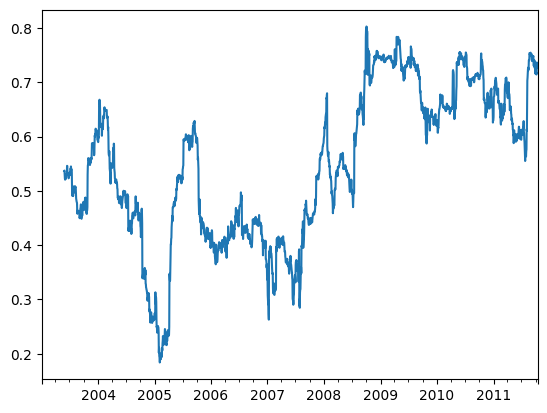

In [21]:
spx_px = close_px_all['SPX']
spx_rets = spx_px.pct_change()
returns = close_px.pct_change()
corr = returns.AAPL.rolling(125, min_periods=100).corr(spx_rets)
corr.plot()
# The corr aggregation function after we call rolling can then compute the rolling
# correlation with spx_rets (see Figure 11-8 for the resulting plot):

Suppose you wanted to compute the correlation of the S&P 500 index with many
stocks at once. Writing a loop and creating a new DataFrame would be easy but might
get repetitive, so if you pass a Series and a DataFrame, a function like rolling_corr
will compute the correlation of the Series (spx_rets, in this case) with each column
in the DataFrame (see Figure 11-9 for the plot of the result):

<Axes: >

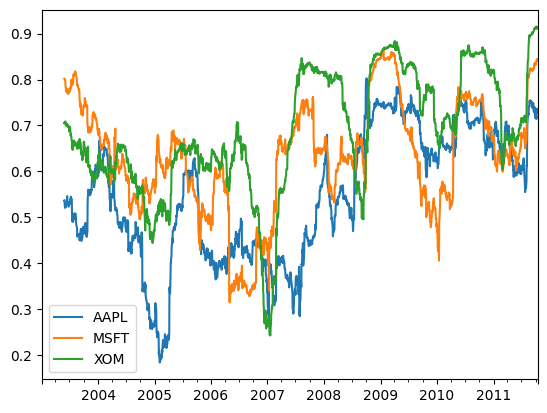

In [22]:
corr = returns.rolling(125, min_periods=100).corr(spx_rets)
corr.plot()

### User-Defined Moving Window Functions

The apply method on rolling and related methods provides a means to apply an
array function of your own devising over a moving window. The only requirement is
that the function produce a single value (a reduction) from each piece of the array.
For example, while we can compute sample quantiles using rolling(...).quan
tile(q), we might be interested in the percentile rank of a particular value over the
sample. The scipy.stats.percentileofscore function does just this (see
Figure 11-10 for the resulting plot):

<Axes: >

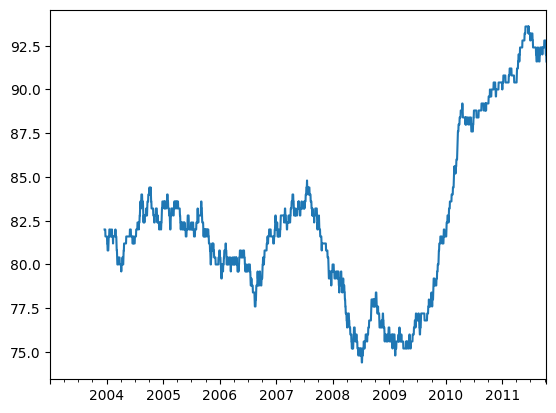

In [23]:
from scipy.stats import percentileofscore
score_at_2percent = lambda x: percentileofscore(x, 0.02)
result = returns.AAPL.rolling(250).apply(score_at_2percent)
result.plot()